In [1]:
from cvae_test import cVAE
import torch
import numpy as np
import mdtraj as md
from utils import voxel_gauss, avg_blob, rigid_transform#, mean_center
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda')

In [3]:
path = '/project2/andrewferguson/Kirill/c2f_vae_final/ADP_logs_final/version_1/checkpoints/N-Step-Checkpoint.ckpt'

In [4]:
model = cVAE.load_from_checkpoint(checkpoint_path=path,
                                  path='../midway3_c2f/ADP_data/').to(device)
model.eval()
model.device

device(type='cuda', index=0)

In [5]:
model.setup(None)

Atoms in AA: ['H1', 'CH3', 'H2', 'H3', 'C', 'O', 'N', 'H', 'CA', 'HA', 'CB', 'HB1', 'HB2', 'HB3', 'C', 'O', 'N', 'H', 'C', 'H1', 'H2', 'H3']
AA trajectory with 500000 frames, 22 atoms
CG trajectory with 500000 frames, 6 atoms
Using 475000 frames for training, 25000 for validation.


In [6]:
z, Energies = model.estimate_latent_space_density()

Fitting GMM to posterior latent space density...


In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import pearsonr
sns.set(style='white')

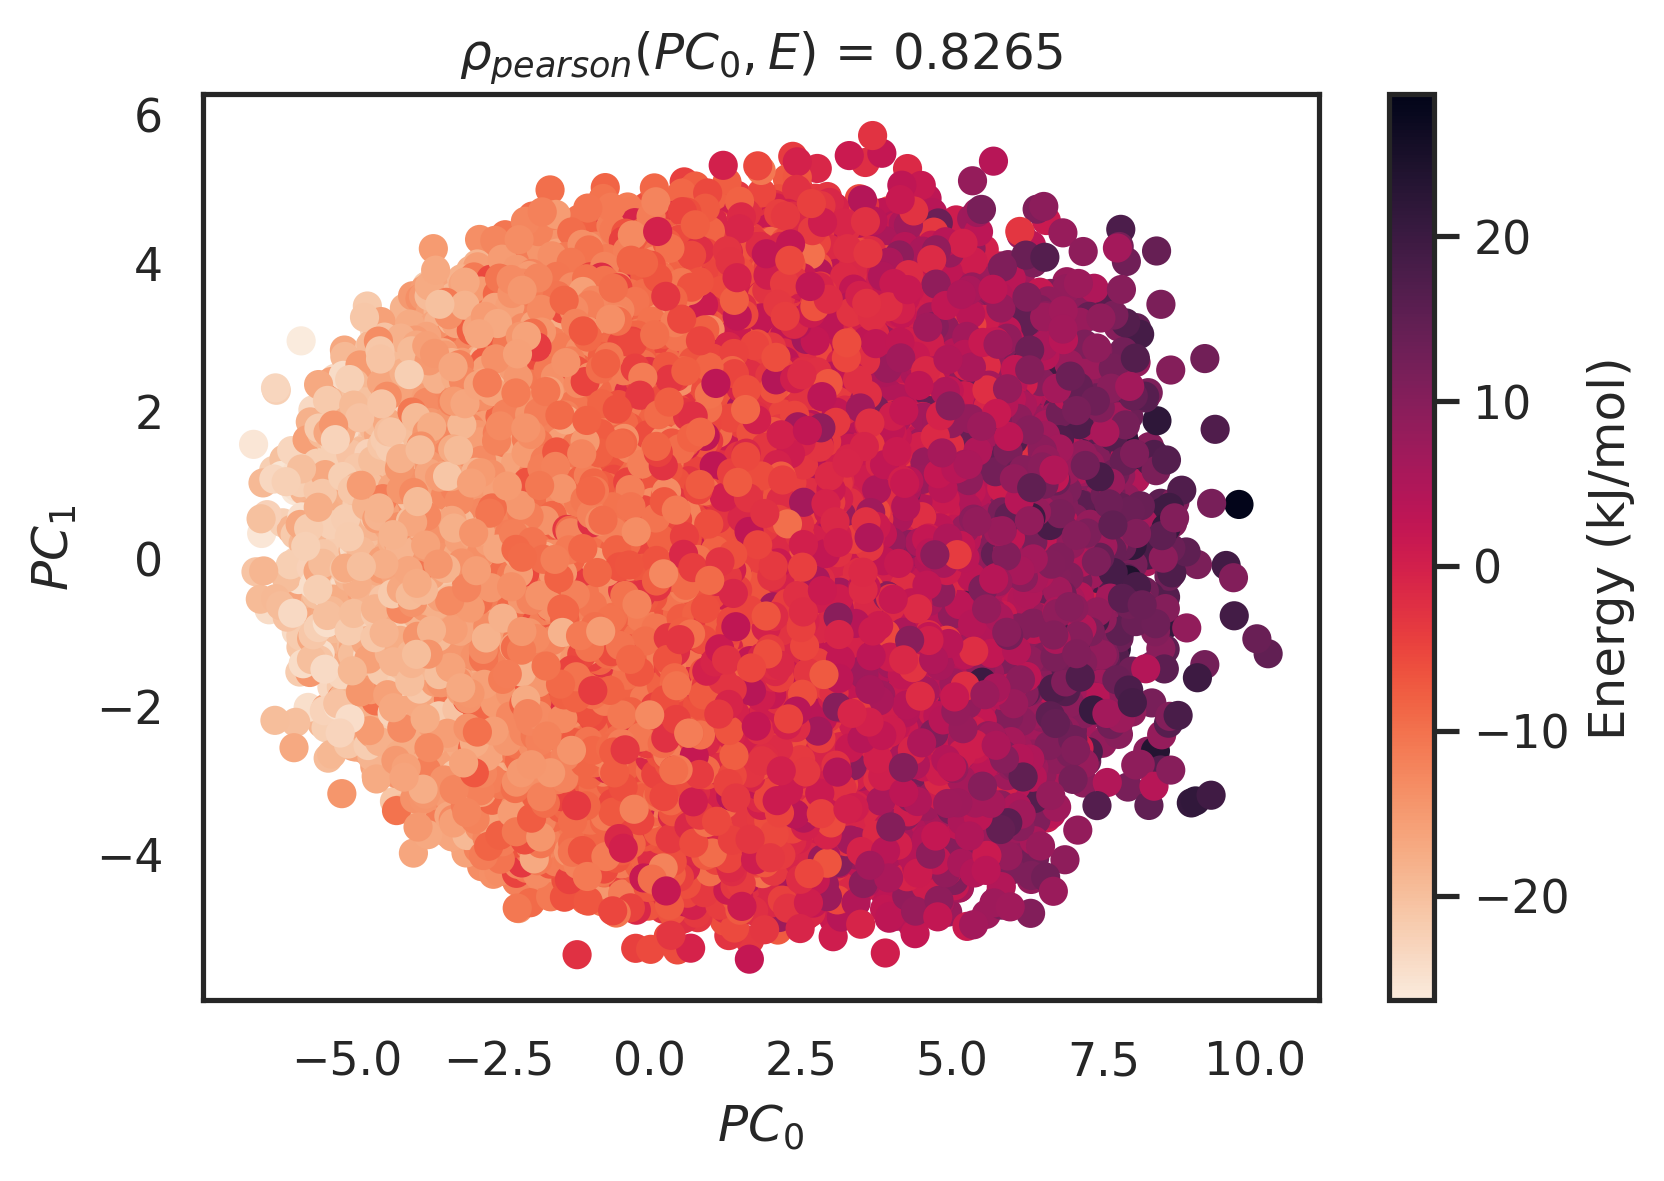

In [8]:
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)
plt.figure(dpi=300)
cmap = ListedColormap(sns.color_palette("rocket_r", n_colors=256).as_hex())
im = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=Energies.flatten(), cmap=cmap)
plt.colorbar(im, orientation='vertical', label='Energy (kJ/mol)')
plt.title("$\\rho_{pearson}(PC_0, E)$ = " + f'{pearsonr(z_pca[:, 0], Energies.flatten())[0]:.4g}')
plt.xlabel('$PC_0$')
plt.ylabel('$PC_1$')
plt.show()

In [9]:
cg_data = np.load('ALA2_regular_avg_cgtraj.npy') / 10.
cg_data.shape

(100, 100000, 6, 3)

In [10]:
all_coords = list()
for frame in tqdm(range(cg_data.shape[0])):
    cg_data_trj = md.Trajectory(cg_data[frame], topology=model.cg_traj.top).center_coordinates()
    aa_argmin = md.rmsd(model.cg_traj, cg_data_trj, frame=0).argmin()

    aa_0 = model.aa_traj[aa_argmin]
    R, t = rigid_transform(aa_0.atom_slice(model.cg_idxs).xyz[0], cg_data_trj.xyz[0])
    aa_0 = model.aa_traj[aa_argmin - 1]
    aa_0.xyz = aa_0.xyz @ R + t

    with torch.no_grad():
        aa_vox_current = voxel_gauss(
            torch.Tensor(aa_0[0].xyz).to(model.device),
            res=model.hparams.resolution,
            width=model.hparams.length,
            sigma=model.hparams.sigma,
            device=model.device)

        fake_coords = list()
        for i in tqdm(range(cg_data_trj.n_frames), leave=False):
            cg_vox = voxel_gauss(
                torch.Tensor(cg_data_trj[i].xyz).to(model.device),
                res=model.hparams.resolution,
                width=model.hparams.length,
                sigma=model.hparams.sigma,
                device=model.device)

            condition = torch.cat((cg_vox, aa_vox_current), dim=1)

            z = model.sample_GMM_latent_space()

            recon_aa_vox = model.decode(z, condition)

            aa_fake = avg_blob(
                recon_aa_vox,
                res=model.hparams.resolution,
                width=model.hparams.length,
                sigma=model.hparams.sigma,
                device=model.device,
            )
            aa_fake = aa_fake - aa_fake.mean(dim=1)
            fake_coords.append(aa_fake)

            aa_vox_current = voxel_gauss(
                aa_fake,
                res=model.hparams.resolution,
                width=model.hparams.length,
                sigma=model.hparams.sigma,
                device=model.device)
            
    hallucinate_coords = torch.cat(fake_coords, dim=0)
    all_coords.append(hallucinate_coords)
    hallucinate_trj = md.Trajectory(hallucinate_coords.detach().cpu().numpy(), topology=model.aa_traj.top)
    hallucinate_trj.save_dcd(f'ADP_cg2aa_hallucinate/aa_hallucinate_{frame}.dcd')
    cg_data_trj.save_dcd(f'ADP_cg2aa_hallucinate/cg_real_{frame}.dcd')